# K-Means Clustering Example (Unsupervised Grouping)
Here is demonstrated how to use the KMeans module from the `rice_ml` library to perform centroid-based clustering.\
In this example, a synthetically generated dataset with well-defined globular clusters will be used to train and evaluate the model.\
**Goal: Partition the dataset into $K$ distinct groups by minimizing the distance between points and their assigned cluster center.**

In [8]:
import numpy as np
from sklearn.datasets import make_blobs 
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from rice_ml.unsupervised_learning.k_means_clustering import KMeans

from rice_ml.processing.preprocessing import train_test_split, standardize



## 1. Load Data and Preparation
Use the `make_blobs` dataset, which generates a perfect example of isotropic (circular) clusters, ideally suited for K-Means.

In [2]:
# Generate synthetic data with 4 distinct clusters
N_CLUSTERS_TRUE = 4
X_raw, y_true = make_blobs(
    n_samples = 300, 
    n_features = 2,
    centers = N_CLUSTERS_TRUE, 
    cluster_std = 1.0, # Standard deviation for tight clusters
    random_state = 67
)

print(f"Total Samples in Dataset: {X_raw.shape[0]}")
print(f"True Number of Centers: {N_CLUSTERS_TRUE}")

Total Samples in Dataset: 300
True Number of Centers: 4


## 2. Data Splitting and Pre-Processing: Scaling with `standardize`
Perform a train-test split first. Then, use the `standardize` function to scale the training data, capturing the scaling parameters (mean and standard deviation). Finally, apply those same captured parameters to transform the test data, preventing data leakage.

In [4]:
# 1. Split data into training and test sets
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_raw, y_true, test_size=0.3, random_state=67
)

# 1. Fit the scaler on the training set and capture the parameters
X_train_scaled, params = standardize(X_train_raw, return_params=True)

# 2. Apply the fit to the test set using the captured parameters
X_test_scaled = standardize(
    X_test_raw, 
    mean=params['mean'], 
    scale=params['scale']
)

print(f"\nTraining data scaled successfully. Parameters learned from training set.")
print(f"Test data scaled successfully using training set parameters.")
print(f"Shape of X_train_scaled: {X_train_scaled.shape}")


Training data scaled successfully. Parameters learned from training set.
Test data scaled successfully using training set parameters.
Shape of X_train_scaled: (210, 2)


## 3. Initialize and Run the Model 
Train the models on the scaled training data (`X_train_scaled`) comparing the effect of 'random' and 'k-means++' initialization.

In [5]:
K = 4 # We tell the model to find the true number of clusters

# --- Model 1: Random Initialization ---
kmeans_random = KMeans(
    n_clusters = K, 
    init = 'random',
    max_iter = 50, 
    random_state = 67
)
print("\nTraining Model (Random Init) on X_train_scaled...")
kmeans_random.fit(X_train_scaled) # Fit on scaled training data

# --- Model 2: K-Means++ Initialization (Preferred) ---
kmeans_plusplus = KMeans(
    n_clusters = K, 
    init = 'k-means++',
    max_iter = 50, 
    random_state = 67
)
print("\nTraining Model (K-Means++ Init) on X_train_scaled...")
kmeans_plusplus.fit(X_train_scaled) # Fit on scaled training data


Training Model (Random Init) on X_train_scaled...
K-Means converged after 7 iterations.

Training Model (K-Means++ Init) on X_train_scaled...
K-Means converged after 2 iterations.


## 4. Evaluation and Comparison (on Training Data and Test Data)
Compare the Inertia (WCSS) score of the two models on the training data. Then, we use the better model (K-Mean++) to predict clusters on the scaled test data and evaluate its inertia there.

In [6]:
print("\n--- Model Comparison on Training Data ---")
print(f"Random Init Model Training Inertia: {kmeans_random.inertia_:.2f}")
print(f"K-Means++ Init Model Training Inertia: {kmeans_plusplus.inertia_:.2f}")

# Predict on the scaled test data
test_labels = kmeans_plusplus.predict(X_test_scaled)

# Calculate inertia for test data (manually, as 'predict' doesn't return it)
test_inertia = 0.0
for i, label in enumerate(test_labels):
    distance = np.linalg.norm(X_test_scaled[i] - kmeans_plusplus.cluster_centers_[label])
    test_inertia += distance ** 2

print(f"\n--- Evaluation on Test Data (K-Means++ Model) ---")
print(f"K-Means++ Model Test Inertia: {test_inertia:.2f}")


--- Model Comparison on Training Data ---
Random Init Model Training Inertia: 57.55
K-Means++ Init Model Training Inertia: 14.60

--- Evaluation on Test Data (K-Means++ Model) ---
K-Means++ Model Test Inertia: 6.33


## 5. Visualization of Clusters (Test Data)
Visualize the results of the K-Means++ model on the scaled test data, plotting the clustered points and the final centroids.

C:\Users\erida\AppData\Local\Temp\ipykernel_18368\2368992100.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap=plt.cm.get_cmap('viridis', K), # Use 'viridis' for K colors


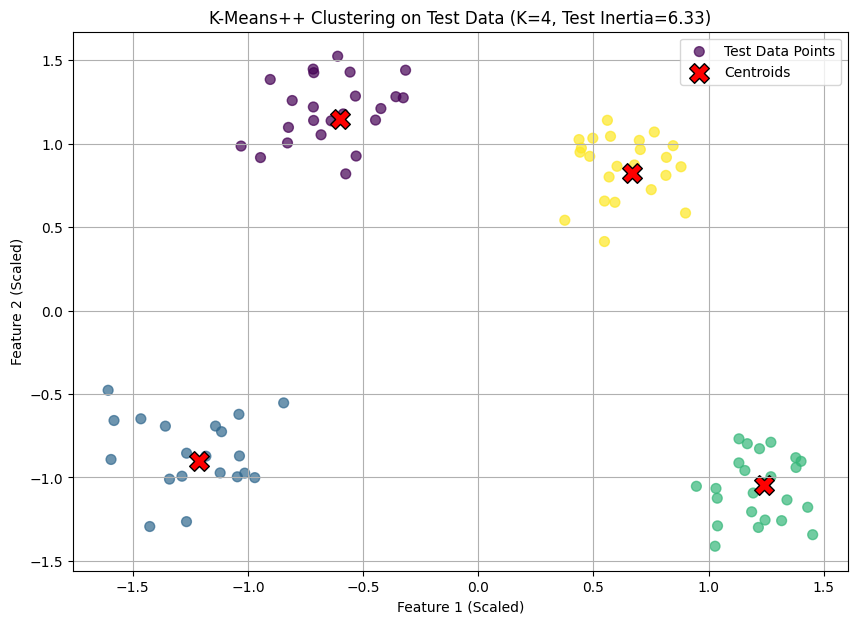

In [9]:
# Use the results from the K-Means++ model fitted on training data
final_labels_test = kmeans_plusplus.predict(X_test_scaled)
final_centers = kmeans_plusplus.cluster_centers_ # Learned from training data

plt.figure(figsize=(10, 7))

# Scatter plot of the TEST data, colored by cluster label
plt.scatter(X_test_scaled[:, 0], X_test_scaled[:, 1], 
            c=final_labels_test,               # Color points by cluster index
            cmap=plt.cm.get_cmap('viridis', K), # Use 'viridis' for K colors
            s=50, 
            alpha=0.7, 
            label='Test Data Points')

# Plot the final Centroids (these are in the scaled feature space)
plt.scatter(final_centers[:, 0], final_centers[:, 1], 
            marker='X',                   # Use an 'X' marker
            s=200,                        # Large size for visibility
            c='red',                      # Red color
            edgecolors='black',           # Black outline
            label='Centroids')

plt.title(f'K-Means++ Clustering on Test Data (K={K}, Test Inertia={test_inertia:.2f})')
plt.xlabel('Feature 1 (Scaled)')
plt.ylabel('Feature 2 (Scaled)')
plt.legend()
plt.grid(True)
plt.show()